In [43]:
import gdown
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping


### Loading Data

In [ ]:
# Downlaoding Data

def data_download():
    g_url = "https://drive.google.com/file/d/1vlhZ5c7abUKF8xXERIw6m9Te8fW7ohw3/view?usp=sharing"
    url_id = g_url.split('/')[-2] # Extracting ID from Link
    down_url = 'https://drive.google.com/uc?/export=download&id=' #Downlaod Link
    print(down_url + url_id) #Combining Download Link and ID
    gdown.download(down_url + url_id, output="kidney_disease_data.zip", quiet=False) #Downloading Data
    print("Download Complete")

data_download()

https://drive.google.com/uc?/export=download&id=1vlhZ5c7abUKF8xXERIw6m9Te8fW7ohw3


Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1vlhZ5c7abUKF8xXERIw6m9Te8fW7ohw3
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1vlhZ5c7abUKF8xXERIw6m9Te8fW7ohw3&confirm=t&uuid=0a095bda-2f7e-474c-90d1-df34bec064cb
To: /content/kidney_disease_data.zip
100%|██████████| 57.7M/57.7M [00:01<00:00, 38.4MB/s]

Download Complete


In [ ]:
import zipfile

zip_file = zipfile.ZipFile('/content/kidney_disease_data.zip', 'r')
zip_file.extractall('/content')
zip_file.close()

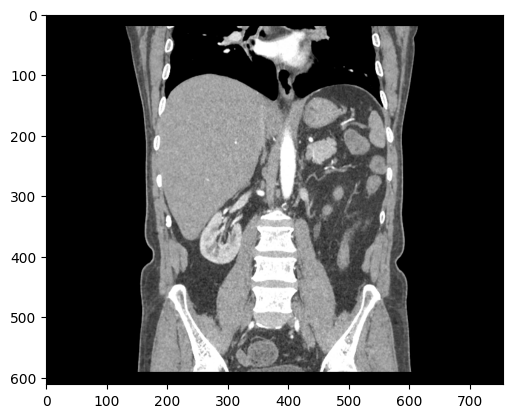

In [24]:
img1 = mpimage.imread(r"/content/kidney-ct-scan-image/Normal/Normal- (637).jpg")
plt.imshow(img1)
plt.show()

In [25]:
# Images

# Paths
normal_path = r"/content/kidney-ct-scan-image/Normal"
tumoor_path = r"/content/kidney-ct-scan-image/Tumor"

def load_images(path, rows, col):
    images = int(rows) * int(col)
    files = os.listdir(path)
    for i, file in enumerate(files[:images]):
        img = mpimage.imread(os.path.join(path, file))

        plt.subplot(rows, col, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

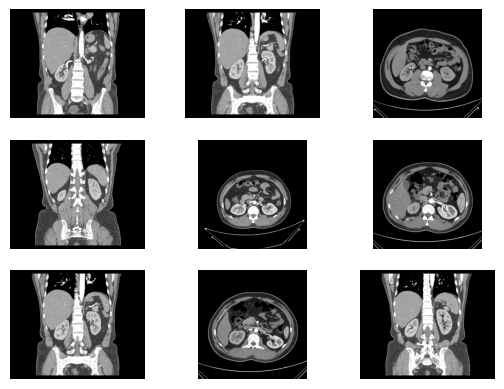

In [26]:
load_images(normal_path, 3, 3)

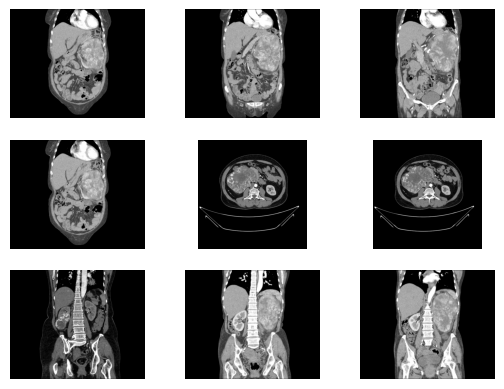

In [27]:
# tumor
load_images(tumoor_path, 3, 3)

### Image Preprocessing

In [28]:
def image_checker(file_paths):
    valid= []
    not_valid = []
    for image in os.listdir(file_paths):
        try:
            img = Image.open(os.path.join(file_paths, image))
            img.verify()
            valid.append(f"{image}: Image is valid")
        except(IOError, SyntaxError):
            not_valid.append(f"{image}: Image is not valid")

    return valid, not_valid

In [29]:
valid_images, not_valid = image_checker(normal_path)
print(f'Valid Images: {len(valid_images)}')
print(f'Not Valid Images: {len(not_valid)}')

Valid Images: 240
Not Valid Images: 0


In [30]:
valid_images, not_valid = image_checker(tumoor_path)
print(f'Valid Images: {len(valid_images)}')
print(f'Not Valid Images: {len(not_valid)}')

Valid Images: 225
Not Valid Images: 0


In [31]:
based_dir = r"/content/kidney-ct-scan-image"
gen_data = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
    )

In [32]:
# Train Data Set
train_data = gen_data.flow_from_directory (
    based_dir,
    target_size = (224, 224),
    batch_size = 32,
    subset='training',
    class_mode='binary'
)

test_data = gen_data.flow_from_directory(
    based_dir,
    target_size = (224, 224),
    batch_size = 32,
    subset='validation',
    class_mode='binary'
)

Found 372 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


## MODEL

In [52]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224,3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation = "relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [53]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 55, 55, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 193600)            0         
                                                                 
 dense_16 (Dense)            (None, 50)               

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [55]:
history = model.fit(train_data, epochs=10, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/10
12/12 [==============================] - 42s 3s/step - loss: 1.1000 - accuracy: 0.5941 - val_loss: 0.7148 - val_accuracy: 0.5269
Epoch 2/10
12/12 [==============================] - 41s 3s/step - loss: 0.5055 - accuracy: 0.7930 - val_loss: 0.8065 - val_accuracy: 0.5914
Epoch 3/10
12/12 [==============================] - 41s 3s/step - loss: 0.3308 - accuracy: 0.8656 - val_loss: 0.5922 - val_accuracy: 0.7312
Epoch 4/10
12/12 [==============================] - 40s 3s/step - loss: 0.2346 - accuracy: 0.9140 - val_loss: 0.4217 - val_accuracy: 0.8280
Epoch 5/10
12/12 [==============================] - 40s 3s/step - loss: 0.1957 - accuracy: 0.9274 - val_loss: 0.2307 - val_accuracy: 0.9140
Epoch 6/10
12/12 [==============================] - 40s 3s/step - loss: 0.1577 - accuracy: 0.9301 - val_loss: 0.7728 - val_accuracy: 0.7312
Epoch 7/10
12/12 [==============================] - 39s 3s/step - loss: 0.2255 - accuracy: 0.9409 - val_loss: 0.2398 - val_accuracy: 0.8925
Epoch 8/10
12/12 [==

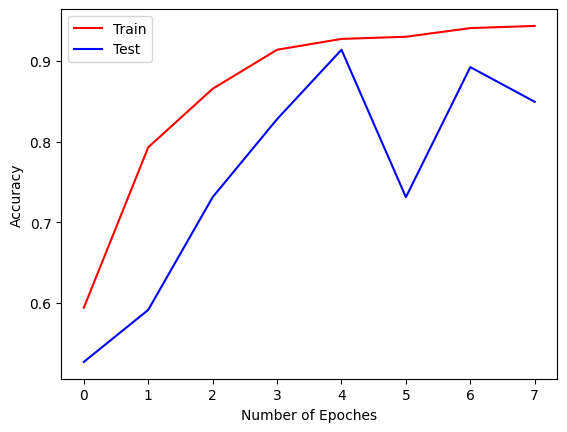

In [67]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.plot(accuracy, color='red')
plt.plot(val_accuracy, color='blue')
plt.xlabel('Number of Epoches')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [68]:
model.save('/content/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
